In [1]:
import numpy as np
from scipy.optimize import minimize,LinearConstraint
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image, display
from scipy.sparse.csgraph import connected_components
import random
np.random.seed(10)

# Discrete Time Markov Chains
This is an exercise notebook on DTMCs. 

Remember to revise of the lecture on DTMC before attempting to solve it! 

### Models

Consider few DTMCs, those seen in the lectures and few more:

1. A student goes to a concert and alternates between being "dancing" and being "at the bar" until, at a certain point, it goes home which is an absorbing state. Model this scenario as a DTMC, draw the diagram and define the respective transition matrix, called `transition_concert`.  

Give names to states and use a dictionary to match names with indexes in the matrix.


Always check that the defined transition matrix is **well-defined**.

True


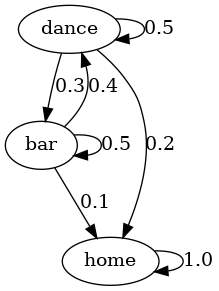

In [2]:
activities={"dance":0,"bar":1,"home":2}
transition_concert=np.zeros([3,3])
transition_concert[0,0]=0.5
transition_concert[0,1]=0.3
transition_concert[0,2]=0.2
transition_concert[1,0]=0.4
transition_concert[1,1]=0.5
transition_concert[1,2]=0.1
transition_concert[2,0]=0
transition_concert[2,1]=0
transition_concert[2,2]=1
# this command checks that all rows sum to 1
print(set(np.sum(transition_concert,axis=1).tolist())=={1.0})

def get_label(my_dict,val):
    for key, value in my_dict.items():
            if val == value:
                return key


def plot_dtmc(labels, transition_matrix):
    n=len(transition_matrix)
    G = nx.MultiDiGraph()
    G.add_nodes_from(labels.keys())
    for i in range(n):
        for j in range(n):
            if transition_matrix[i,j]>0:
                G.add_edge(get_label(labels,i),get_label(labels,j),weight=transition_matrix[i,j],label=transition_matrix[i,j])
    
    pdot=nx.drawing.nx_pydot.to_pydot(G)
    plt = Image(pdot.create_png())
    display(plt)
    
plot_dtmc(activities,transition_concert)


2. Consider a walker moving randomly along the star graph shown below. The graph is composed of six states. State 6 is the terminal point. 

<img src="imgs/star_graph.png" width="300">

Model the movement of the walker as a DTMC. Choose the parameters $a,b,c,d,e,f,e\in (0,1)$ so that the transition matrix, `transition_star`, is well-defined.
Keep in mind that, ingoing and outgoing transitions can happen with different probabilities.

In [3]:
transition_star=np.zeros([6,6])
#initializing non zero parameters (sto assumendo che ci sia una freccia anche al contrario per ogni lettera tranne la b,
# dal disegno non è chiaro)
transition_star[0,4]=np.random.rand()
transition_star[4,1]=np.random.rand()
transition_star[1,2]=np.random.rand()
transition_star[2,3]=np.random.rand()
transition_star[4,1]=np.random.rand()
transition_star[4,0]=np.random.rand()
transition_star[1,4]=np.random.rand()
transition_star[2,1]=np.random.rand()
transition_star[3,2]=np.random.rand()
transition_star[1,4]=np.random.rand()
transition_star[1,5]=np.random.rand()
transition_star[5,5]=np.random.rand()

#normalizing to have a well-defined matrix
for i in range(6):
    transition_star[i,:]=transition_star[i,:]/np.sum(transition_star[i,:])


3. A general birth-death chain, `transition_birth_death()`. Define it writing a function that takes `N` as input (the maximum population size) and vectors `p` (the birth probability) and `q` (the death probability) of length N and returns the transition matrix `transition_birth_death`.

<img src="imgs/birth-death.png" width="600">

In [4]:
def create_transition_birth_death(n,p,q):
    A=np.zeros([n,n])
    A[0,0]=1-p[0]
    A[0,1]=p[0]
    for i in range(1,n-1):
        A[i,i]=1-p[i]-q[i]
        A[i,i-1]=q[i]
        A[i,i+1]=p[i]
    A[n-1,n-2]=q[n-1]
    A[n-1,n-1]=1-q[n-1]
    return A

In [5]:
transition_birth_death=create_transition_birth_death(3,[0.4,0.3,0.3],[0.3,0.1,0.2])
print(transition_birth_death)

[[0.6 0.4 0. ]
 [0.1 0.6 0.3]
 [0.  0.2 0.8]]


4. **Queue model**. Queuing chains model the number of customers in the system as a function of time, and in particular, whether the server(s) can adequately handle the flow of customers. 
Let $X_n$ be the number of custumers in the system at time $n\in \mathbb{N}$. 
Define a DTMC that models a queueing system where the costumer propensity to join the system, i.e. the arrival rate, is inversely proportional to the current length of the queue.


Draw the transitions graph, the transition matrix and explain the details of your model in the two following scenarios:

4.1. **Single server**: the service is provided by a single server with service rate $\mu$


<img src="imgs/xqueue.png" width="300">


4.2. $m$ **servers**: the service is provided by $m$ servers each with a service rate $\mu$

<img src="imgs/xqueue_m_servers.png" width="300">

We can use the same model of ex.3 by identifyng the state space as the number of people currently in the queue. I assume $\mu$ is fixed.
I assume $\lambda=\frac{1}{2(n+1)}$ to ensure finite and non-one probability everywhere. I further assume that in one unit of time at most one person can enter the queue and at most person can exit.
Let's start with the single server.

In [6]:
def p(n):
    return 1/(2*(n+1))


def create_single_queue(n,mu):
    A=np.zeros([n,n])
    A[0,0]=1-p(0)
    A[0,1]=p(0)
    for i in range(1,n-1):
        A[i,i]=1-p(i)-mu
        A[i,i-1]=mu
        A[i,i+1]=p(i)
    A[n-1,n-2]=mu
    A[n-1,n-1]=1-mu
    return A


print(create_single_queue(10,0.1))

[[0.5        0.5        0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1        0.65       0.25       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.1        0.73333333 0.16666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.1        0.775      0.125      0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.1        0.8        0.1
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.1        0.81666667
  0.08333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.1
  0.82857143 0.07142857 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.1        0.8375     0.0625     0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.1        0.84444444 0.05555556]
 [0.         0.         0. 

In the case of multiple server we will permit the exit probability to vary from $\mu$ to $m\mu$ if there are enough people in the queue. Of course we must impose $m\mu<1$ to ensure well-definess.


In [7]:
def create_multiple_queue(n,mu,m):
    A=np.zeros([n,n])
    A[0,0]=1-p(0)
    A[0,1]=p(0)
    for i in range(1,n-1):
        A[i,i]=1-p(i)-min(i,m)*mu
        A[i,i-1]=min(i,m)*mu
        A[i,i+1]=p(i)
    A[n-1,n-2]=min(n-1,m)*mu
    A[n-1,n-1]=1-min(n-1,m)*mu
    return A

print(create_multiple_queue(10,0.1,5))

[[0.5        0.5        0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.1        0.65       0.25       0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.2        0.63333333 0.16666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.3        0.575      0.125      0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.4        0.5        0.1
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.5        0.41666667
  0.08333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.42857143 0.07142857 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.5        0.4375     0.0625     0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.5        0.44444444 0.05555556]
 [0.         0.         0. 

### Transient probability
Write a function that takes a DTMC as input (both the transition matrix `transition_model` and the initial probability `prob_init_model`) and the number of steps `n`, and returns the probability `prob_model` of being in each state after `n` steps. Plot the output as an histogram. 
*Extra*: compute the transient probabilities from time 0 to time `n` and visualize this output as a 2d colormap, with one axis representing states, and the other time. 


[2.96841968e-37 2.57072685e-37 1.00000000e+00]
It converges :-)


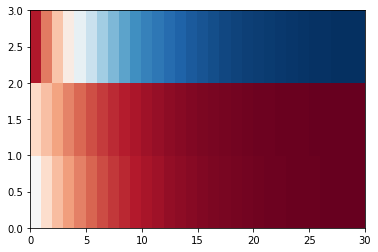

In [8]:
def transient_probability(transition_model, probability_init_model,n):    
    return np.dot(probability_init_model,np.linalg.matrix_power(transition_model, n))

print(transient_probability(transition_concert,[0.5,0.4,0.1],500))
print("It converges :-)")
def create_colormap(transition_model, probability_init_model,n):
    A=np.zeros([len(transition_model),n])
    for i in range(n):
        A[:,i]=transient_probability(transition_model, probability_init_model,i)
    
    plot=plt.pcolormesh( [i for i in range(n+1)], [i for i in range(len(transition_model)+1)], A, cmap='RdBu', shading='flat')
    
create_colormap(transition_concert,[0.5,0.4,0.1],30)


### Reachability (absorption probability) and hitting times.
Write a function that takes as input:
- a DTMC (the transition matrix `transition_model` is enough),
- a subset of states `target_region` (either specified by their name or by their indices).
The function should compute a vector `prob_absorption_model`, containing the **absorption probability** for each state. Use the iterative method discussed in the lecture. 

Implement also a method with the same input, returning the **expected hitting times** `exp_hitting_time_model`.

In [9]:
def calc_absorption_probability(transition_model,target_region,eps):
    A=transition_model.copy()
    n=len(A)
    v=np.zeros(n)
    
    for i in target_region:
        A[i,:]=np.zeros([1,n])
        A[i,i]=1
        v[i]=1
        err=float('inf')
    while err>eps:
        v2=np.dot(A,v)
        err=np.linalg.norm(v-v2)
        v=v2
    return v

def calc_hitting_time(transition_model,target_region):
    A=transition_model.copy()
    n=len(A)
    vl=np.zeros(2*n)
    vu=np.zeros(2*n)
    s=set( i for i in range(n))-set(target_region)
    
    for i in target_region:
        A[i,:]=np.zeros([1,n])
        A[i,i]=1
        v[i]=0
    
    for i in s:
        A[i,i]=A[i,i]-1
        vl[i]=-1

    
    
    def objfun(x):
        return np.dot(x,x)
    
    def hess(x):
        return 2*np.eye(n)
    
    
    sol = minimize(objfun, np.ones(n),hess=hess , method="trust-constr", constraints=LinearConstraint(A,v,v),bounds=((0,np.inf) for i in range(n)))
    return sol.x

v=calc_absorption_probability(transition_concert,[0],10e-03)
print(v)
w=calc_hitting_time(transition_concert,[0])
print(w)

[1.      0.79375 0.     ]


/usr/local/lib/python3.6/site-packages/scipy/optimize/_trustregion_constr/projections.py:183: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  'perform the factorizations.')


[5.33826161e-16 1.60425010e-02 8.01771250e+00]


### Steady state probability

Write a function taking as input a DTMC and computes its steady state probability, assuming the chain is irreducible, aperiodic, and finite. 
*Extra*: explore Python libraries and find one implementing graph algorithms. Use a method to compute strongly connected components to check if a chain is irreducible. 

If a chain is not irreducible, feel free to make it reducible adding transitions where needed.

In [10]:
def check_irreducible(transition_model):
    n_components, labels=connected_components(transition_model, directed=True, connection='strong', return_labels=True)
    return n_components==1

def check_aperiodic(transition_model):
    return sum(np.diag(transition_model))>0


def make_irreducible(transition_model):
    A=transition_model.copy()
    n_components, labels=connected_components(A, directed=True, connection='strong', return_labels=True)
    while n_components>1:
        index0=np.where(labels==0)[0][0]
        index1=np.where(labels==1)[0][0]
        A[index0,index1]=np.random.rand()
        A[index0,:]=A[index0,:]/sum(A[index0,:])
        A[index1,index0]=np.random.rand()
        A[index1,:]=A[index1,:]/sum(A[index1,:])
        n_components, labels=connected_components(A, directed=True, connection='strong', return_labels=True)
    return A

def make_aperiodic(transition_model):
    A=transition_model.copy()
    A[0,0]=numpy.random.rand()
    A[0,:]=A[0,:]/sum(A[0,:])
    return A
    
def steady_state_probability(transient_model, probability_init_model,eps):
    A=transient_model.copy()
    if not check_irreducible(A):
        A=make_irreducible(A)
    if not check_aperiodic(A):
        A=make_aperiodic(A)
    err=1+eps
    v=probability_init_model.copy()
    probability_init_model_old=probability_init_model.copy()
    while err>eps:
        v=np.dot(probability_init_model_old,A)
        err=np.linalg.norm(v-probability_init_model_old)
        probability_init_model_old=v.copy()

    return v
print(steady_state_probability(transition_concert,np.array([0.5,0.4,0.1]),10e-08))



[0.00890195 0.00407047 0.98702758]


#### Model class

Implement a class having all the methods to initialize a DTMC, to compute transient behaviour, steady state behaviour, and reachability. Consider also defining a map linking state numbers to reference meaningful names.

3
[0.19156 0.16587 0.64257]
[0.59999993 1.         0.        ]
False
[5.84637462e-01 4.55703890e-16 1.46159365e+00]
[[0.5 0.3 0.2]
 [0.4 0.5 0.1]
 [0.  0.  1. ]]
[0.4 0.3 0.3]


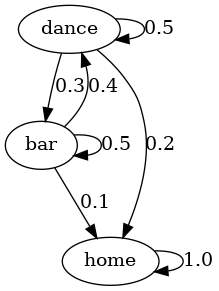

In [11]:
class DTMC:
    def __init__(self,A,b,label):
        self._transitionmodel=A
        self._initialstate=b
        self._label=label
        self._size=len(A)
        
    
    def __len__(self):
        return self._size
    
    def transient_probability(self, n):    
        return np.dot(self._initialstate,np.linalg.matrix_power(self._transitionmodel, n))
    
    def calc_absorption_probability(self,target_region,eps=10e-08):
        A=self._transitionmodel.copy()
        v=np.zeros(self._size)
        
        for i in target_region:
            A[i,:]=np.zeros([1,self._size])
            A[i,i]=1
            v[i]=1
            err=float('inf')
    
        while err>eps:
            v2=np.dot(A,v)
            err=np.linalg.norm(v-v2)
            v=v2
        return v
    
    def check_aperiodic(transition_model):
        return sum(np.diag(transition_model))>0

    
    def check_irreducible(self):
        n_components, labels=connected_components(self._transitionmodel, directed=True, connection='strong', return_labels=True)
        return n_components==1

    def calc_hitting_time(self,target_region):
        A=self._transitionmodel.copy()
        n=self._size
        vl=np.zeros(2*n)
        vu=np.zeros(2*n)
        s=set( i for i in range(n))-set(target_region)
    
        for i in target_region:
            A[i,:]=np.zeros([1,n])
            A[i,i]=1
            v[i]=0
    
        for i in s:
            A[i,i]=A[i,i]-1
            vl[i]=-1

    
    
        def objfun(x):
            return np.dot(x,x)
    
        def hess(x):
            return 2*np.eye(n)
    
    
        sol = minimize(objfun, np.ones(n),hess=hess , method="trust-constr", constraints=LinearConstraint(A,v,v),bounds=((0,np.inf) for i in range(n)))
        return sol.x

    
    def steady_state_probability(self,eps=10e-08):
        A=self._transitionmodel.copy()
        if not (check_irreducible(A) and check_aperiodic(A)):
           print('Warning: matrix not irriducible and/or aperiodic')
        err=1+eps
        v=self._initialstate.copy()
        probability_init_model_old=v.copy()
        while err>eps:
            v=np.dot(probability_init_model_old,A)
            err=np.linalg.norm(v-probability_init_model_old)
            probability_init_model_old=v.copy()

        return v
    

    def transition_model(self):
        return self._transitionmodel
    
    def prob_init_model(self):
        return self._initialstate
    
    def get_label(self,val):
        for key, value in self._label.items():
            if val == value:
                return key
            
    def get_index(self,label):
        return self._label(label)
    
    def plot(self):
        n=self._size
        G = nx.MultiDiGraph()
        G.add_nodes_from(self._label.keys())
        for i in range(n):
            for j in range(n):
                if self._transitionmodel[i,j]>0:
                    G.add_edge(self.get_label(i),self.get_label(j),weight=self._transitionmodel[i,j],label=self._transitionmodel[i,j])
        pdot=nx.drawing.nx_pydot.to_pydot(G)
        plt = Image(pdot.create_png())
        display(plt)


mydtmc=DTMC(transition_concert, np.array([0.4,0.3,0.3]), activities) 
print(len(mydtmc))
print(mydtmc.transient_probability(4))
print(mydtmc.calc_absorption_probability([1]))
print(mydtmc.check_irreducible())
print(mydtmc.calc_hitting_time([1]))
print(mydtmc.transition_model())
print(mydtmc.prob_init_model())
mydtmc.plot()


### Summary exercise
#### Small Monopoly: 

The game Small Monopoly is played on a
game board that has 16 spaces arranged around the outside of a square. The squares
have names like Reading Railroad and Park Place but we will number the squares
0 (Go), 1 (Baltic Avenue), ..., 15 (Boardwalk). You roll two dice
and move forward a number of spaces equal to the sum. The game ends when you reach or pass Boardwalk.

- Square 12 is “Go to Jail,” which sends you to square 4. If you roll a double, you get out.
- There are two Chance squares at 2 and 10 (diamonds on the graph) where you
draw a card, which can send you to another square. The card is picked (with replacement) from a deck containing all the 16 squares.

- Described this game as a directed graph, i.e. define its transition matrix.
- What is the probability of ending the game?
- How long does a game take on average?

<img src="imgs/monopoly.png" width="300">

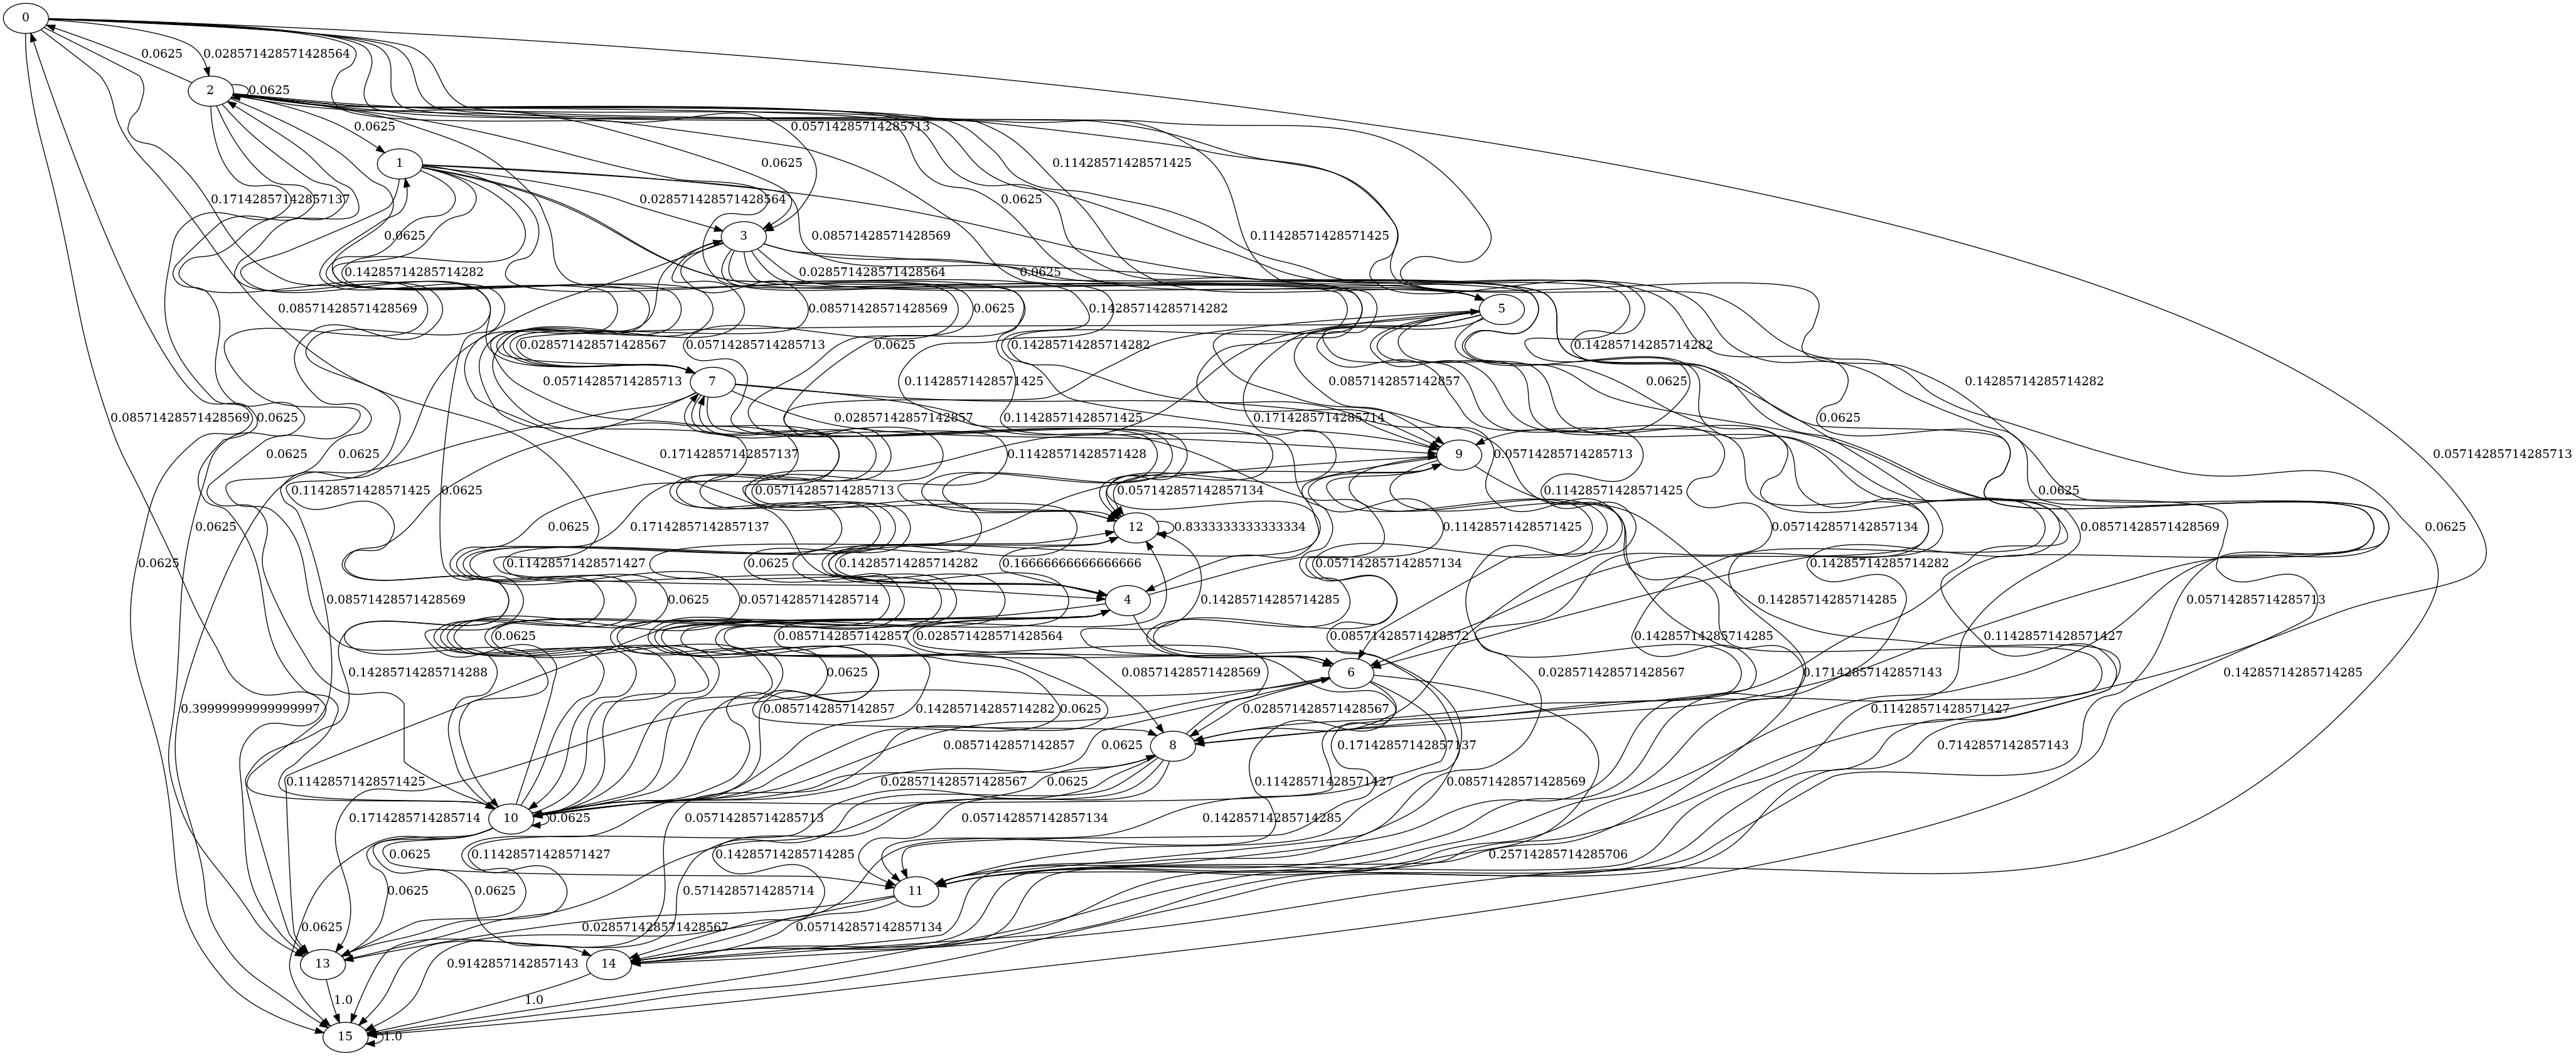

steady state probability of ending the game is 0.9999994785200945


IndexError: index 15 is out of bounds for axis 0 with size 3

In [12]:
monopoly_model=np.zeros([16,16])
dice_prob=1/36*np.array([0.,0.,1.,2.,3.,4.,5.,6.,5.,4.,3.,2.,1.])
for i in range(16):
    for j in range(12):
        if i+j<=15:
            monopoly_model[i,i+j]=dice_prob[j]
        else:
            monopoly_model[i,15]=monopoly_model[i,15]+dice_prob[j]
    #adjustment needed for machine number approximation problems
    monopoly_model[i,:]=monopoly_model[i,:]/sum(monopoly_model[i,:])

monopoly_model[2,:]=monopoly_model[10,:]=1/16*np.ones(16)
monopoly_model[12,:]=0
monopoly_model[12,4]=1/6
monopoly_model[12,12]=5/6
monopoly_model[15,:]=np.zeros(16)
monopoly_model[15,15]=1
initial_prob=np.zeros(16)
initial_prob[0]=1
monopoly_label={'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,'11':11,'12':12,'13':13,'14':14,'15':15}
monopoly_dtmc=DTMC(monopoly_model,initial_prob,monopoly_label)
monopoly_dtmc.plot()
steady=monopoly_dtmc.steady_state_probability()
print("steady state probability of ending the game is",steady[15])
print("average game duration is ", monopoly_dtmc.calc_hitting_time([15])[0])